In [1]:
import numpy as np                 #for general calculations.
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation  #creating animations and videos.
from IPython.display import Video, HTML         #embedding videos in the notebook
import matplotlib
#this command allows interactive plots in noteboks
%matplotlib inline   

In [2]:
from src.models import *
from src.generators import *
from src.losses import *

2023-07-17 00:10:57.576583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 00:10:57.659577: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
p = Path('../data/full_data')
pg = list(p.glob('*.npy'))
pg.sort()

In [4]:
def get_summary_stats(tile_stats):
    sum_0 = tile_stats[:, :, 0]
    sum_1 = tile_stats[:, :, 1]
    sum_2 = tile_stats[:, :, 2]
    
    final_num = np.sum(sum_0)
    if final_num == 0:
        final_mean = 0
        final_std = 1
    else:
        final_mean = np.nansum(sum_1)/final_num
        final_std = np.sqrt(np.nansum(sum_2)/final_num - (final_mean)**2)
    
    return (final_num, final_mean, final_std)

my_data_params = params()
data_dir = my_data_params['dataDir']

tile_stats = np.load(data_dir + '/masked_stats.npy')
stats = get_summary_stats(tile_stats)

train_ids = np.load(data_dir + '/train_ids.npy')
val_ids = np.load(data_dir + '/val_ids.npy')

train_gen = DataGenerator(list_IDs = train_ids, stats = stats, shuffle = True)
val_gen = DataGenerator(list_IDs = val_ids, stats = stats, shuffle = False)


In [5]:
print(len(train_ids) // 12)
print(len(val_ids) // 12)

4214
1190


In [6]:
print(4214 + 1190)

5404


In [4]:
train_gen = DataGeneratorFast(num_batches = len(train_ids) // 12, task = "train", shuffle = True)
val_gen = DataGeneratorFast(num_batches = len(val_ids) // 12, task = "val", shuffle = False)

In [5]:
train_gen.__len__()

4214

In [ ]:
train_gen.__getitem__(10)

In [6]:
batch = train_gen.__getitem__(10)

In [8]:
batch[0].shape

(12, 120, 64, 64)

In [9]:
batch[1].shape

(12, 120, 64, 64)

In [5]:
trained_model = create_ConvLSTM()

2023-07-13 17:31:34.136646: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
trained_model.load_weights('weights/convlstm_sst_attempt_1689025118.h5')

In [11]:
untrained_model = create_ConvLSTM()
untrained_model.compile(loss = mse_loss, optimizer = keras.optimizers.Adam(learning_rate = 5e-4))

In [7]:
trained_model.compile(loss = mse_loss, optimizer = keras.optimizers.Adam(learning_rate = 5e-4))

In [ ]:
trained_model.evaluate(val_gen)

In [10]:
X = batch[0][0, :, :, :]
Y = batch[1][0, :, :, :]

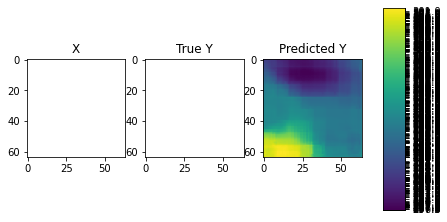

In [39]:
from IPython import display
import time

example = val_gen.__getitem__(10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for i in range(60, 120):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    plot_example(fig, (ax1, ax2, ax3), val_gen, example, 0, i, trained_model)

    display.display(fig)
    display.clear_output(wait=True)
    time.sleep(0.1)

In [30]:
example = val_gen.__getitem__(10)
print((example[0] == 0).sum())
print(np.isnan(example[1]).sum())

4716376
3185109


In [55]:
print(val_gen.__getitem__(0)[0][5, 60, :, :])

[[-1.92457127 -1.94007062 -1.87812045 ... -3.93750285 -3.87559993
  -3.86010058]
 [-1.92457127 -1.92457127 -1.81617028 ... -3.92205075 -3.92205075
  -3.86010058]
 [-1.98652143 -1.87812045 -1.87812045 ... -3.90655139 -3.86010058
  -3.86010058]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [4]:
print(stats)

(215695054.0, 300.2629121076177, 0.6458180705585166)


In [37]:
import time
output = trained_model.predict(example[0])

def plot_example(fig, axs, gen, example, batch_ind, hour, model = create_Zeros()):
    ax1, ax2, ax3 = axs
    
    X = example[0][batch_ind, hour, :, :]
    # print(X)
    Y = example[1][batch_ind, hour, :, :]
    
    X_orig = np.zeros(X.shape)
    X_orig[X != 0] = X[X != 0] * gen.stats[2] + gen.stats[1]
    X_orig[X == 0] = np.nan
    Y_orig = Y * gen.stats[2] + gen.stats[1]
    
    start = time.time()
    Y_pred = output[batch_ind, hour, :, :]
    print(time.time() - start)
    Y_pred_orig = Y_pred * gen.stats[2] + gen.stats[1]
    
    # print(X_orig)
    # print(Y_orig)
    # print(Y_pred_orig)
    vmin = np.nanmin(np.array([np.nanmin(X_orig), np.nanmin(Y_orig), np.nanmin(Y_pred_orig)]))
    vmax = np.nanmax(np.array([np.nanmax(X_orig), np.nanmax(Y_orig), np.nanmax(Y_pred_orig)]))
    print(vmin, vmax)
    im1 = ax1.imshow(X_orig, vmin = vmin, vmax = vmax)
    ax1.set_title('X')
    im2 = ax2.imshow(Y_orig, vmin = vmin, vmax = vmax)
    ax2.set_title('True Y')
    im3 = ax3.imshow(Y_pred_orig, vmin = vmin, vmax = vmax)
    ax3.set_title('Predicted Y')
    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(im2, cax=cbar_ax)
    


In [16]:
example = val_gen.__getitem__(index)
x = example[0]
print(x.shape)

(12, 120, 64, 64)


In [ ]:
model = create_ConvLSTM()
model.compile(loss = mse_loss, optimizer = keras.optimizers.Adam(learning_rate = 5e-4))
model.summary()

In [ ]:
model.evaluate(val_gen)

In [ ]:
trained_model = create_ConvLSTM()
trained_model.load_weights('weights/convlstm_sst_attempt_1688677230.h5')
trained_model.compile(loss = mse_loss, optimizer = keras.optimizers.Adam(learning_rate = 5e-4))

In [ ]:
trained_model.evaluate(val_gen)

In [18]:
y_pred = trained_model.predict(x)

1/1 [==============================] - 0s 201ms/step


In [25]:
print(example[1].shape)
print(y_pred.shape)

(12, 120, 64, 64)
(12, 120, 64, 64, 1)


In [ ]:
y_pred.reshape((12, 120, 64, 64))

In [ ]:
print(mse_loss(y_pred, example[1]))

In [ ]:
print(pred)

In [1]:
import pandas as pd
import numpy as np

In [2]:
experiment_dir = "experiments/experiment_2023-07-25_21:37:34.065317"
experiment_params = pd.read_csv(experiment_dir + '/model_params.csv')

In [3]:
print(experiment_params)

   batch_size  src_seed_size  epochs                           src_data_dir  \
0          12            100      50  data_size64_duration6_window2_4hourly   

                                        gan_data_dir  gan_train_frac  \
0  gan/gan_data_size64_duration6_window2_4hourly/...             0.8   

   gan_val_frac  learning_rate  
0           0.1         0.0001  


In [1]:
import pandas as pd
log = pd.read_csv('experiments/experiment_2023-07-26_14:19:25.398247/log.csv')

<AxesSubplot: xlabel='epoch'>

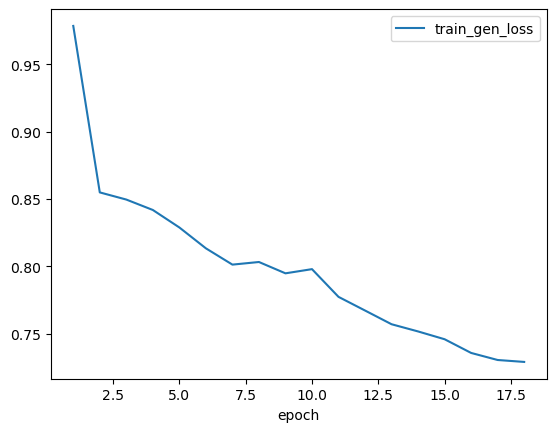

In [2]:
log.plot('epoch', 'train_gen_loss')

In [8]:
print(log)

    epoch  train_gen_loss  train_disc_loss  train_gen_acc  val_gen_loss  \
0       1        0.978470         1.224508       0.506144      0.770891   
1       2        0.854818         1.322576       0.621191      0.601800   
2       3        0.849501         1.306043       0.624867      0.681473   
3       4        0.841763         1.307312       0.628777      0.589244   
4       5        0.828770         1.323470       0.647429      0.838637   
5       6        0.813285         1.336073       0.703530      1.121497   
6       7        0.801181         1.345232       0.729990      0.595571   
7       8        0.803126         1.341080       0.704868      0.620716   
8       9        0.794713         1.344105       0.718131      0.584491   
9      10        0.797822         1.339317       0.698621      0.592907   
10     11        0.777237         1.346958       0.749344      0.595791   
11     12        0.767088         1.349488       0.758930      0.750314   
12     13        0.756901

<AxesSubplot: xlabel='epoch'>

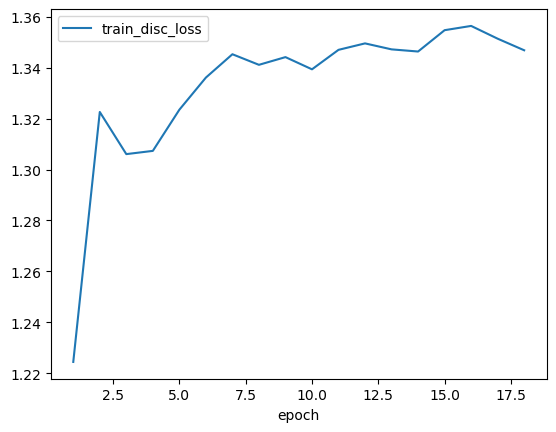

In [3]:
log.plot('epoch', 'train_disc_loss')

<AxesSubplot: xlabel='epoch'>

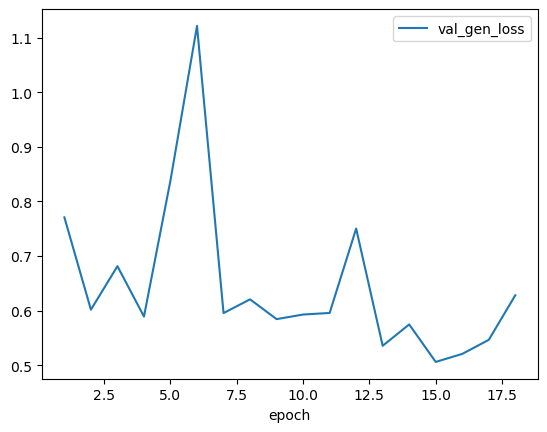

In [4]:
log.plot('epoch', 'val_gen_loss')

<AxesSubplot: xlabel='epoch'>

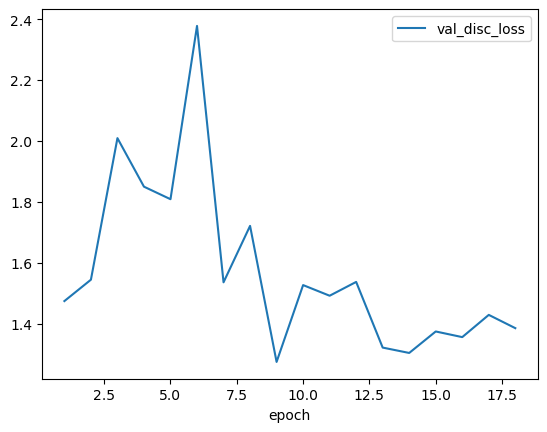

In [5]:
log.plot('epoch', 'val_disc_loss')

<AxesSubplot: xlabel='epoch'>

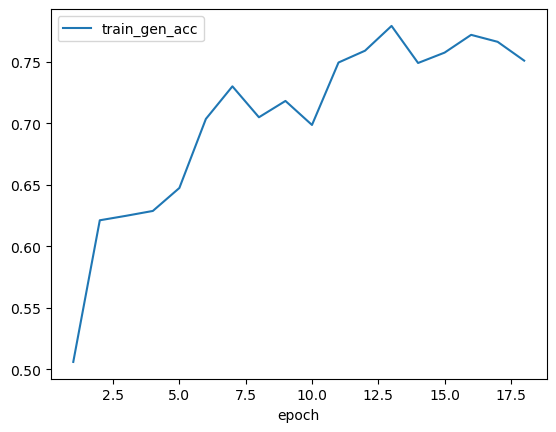

In [6]:
log.plot('epoch', 'train_gen_acc')

<AxesSubplot: xlabel='epoch'>

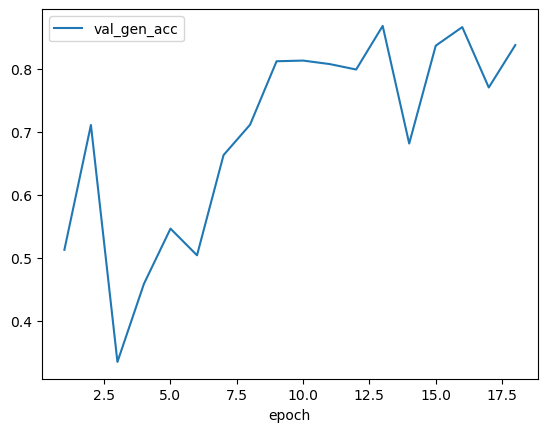

In [7]:
log.plot('epoch', 'val_gen_acc')